**ALGUNAS RECOMENDACIONES**


1. Siempre verificar estacionariedad antes de modelar.
2. Preprocesar la serie de tiempo o signal
3. Graficar la función de autocorrelación (ACF) para identificar rezagos.
4. Usar SNR para validar qué tan robusto es su algoritmo ante fallas de sensores.

**QUE EVITAR:**
1. No ignore los residuos: Si los residuos de su modelo ARIMA no son ruido blanco, el modelo está mal ajustado.
2. Evite la 'Regresión Espuria': Correlacionar dos series no estacionarias (I(1)) dará correlaciones altas falsas.
3. No use filtros de media móvil para predicción en tiempo real sin compensar el retraso (lag).
"""

In [1]:
# =============================================================================
# CHALLENGE 02: ANÁLISIS AVANZADO DE SERIES DE TIEMPO
# Docente: Jorge Iván Padilla-Buriticá | Universidad EAFIT
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from scipy import signal
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns

# Configuración de visualización
plt.style.use('ggplot')
np.random.seed(42)

# =============================================================================
# BLOQUE 1: GENERACIÓN DE SERIES DE TIEMPO (SÍNTESIS DE DATOS)
# Temas: Economía, Clima, Biometría y Energía
# =============================================================================

def generate_signals(n=5000):
    t = np.linspace(0, 500, n)

    # 1. ESTACIONARIA: Frecuencia de red eléctrica (Hz)
    # Media constante, varianza constante, sin tendencia.
    s1 = 60 + np.random.normal(0, 0.05, n)

    # 2. CÍCLICA: Demanda energética diaria
    # Patrón repetitivo sinusoidal puro.
    s2 = 100 + 40 * np.sin(2 * np.pi * t / 24)

    # 3. ESTACIONARIA A TROZOS: Producción industrial por turnos
    # Cambios bruscos en la media pero estable dentro del segmento.
    s3 = np.concatenate([
        np.random.normal(50, 2, n//4),
        np.random.normal(80, 2, n//4),
        np.random.normal(30, 2, n//4),
        np.random.normal(60, 2, n//4)
    ])

    # 4. NO ESTACIONARIA: Precio de Bitcoin (Caminata aleatoria con Drift)
    # La varianza crece con el tiempo, no regresa a la media.
    s4 = 30000 + np.cumsum(np.random.normal(5, 150, n))

    # 5. TENDENCIA LINEAL: Índice de Transformación Digital (Madurez)
    s5 = 0.5 * t + np.random.normal(0, 5, n)

    # 6. ESTACIONAL + TENDENCIA: Concentración CO2 Atmosférico
    s6 = 350 + 0.1 * t + 10 * np.sin(2 * np.pi * t / 12)

    # 7. BIOMÉTRICA: Ritmo Cardíaco (Variabilidad moderada)
    s7 = 75 + 5 * np.sin(t/10) + np.random.normal(0, 1, n)

    # 8. CAÓTICA: Flujo de viento (Intermitencia)
    s8 = 10 + 5 * np.sin(t/5) * np.cos(t/50) + np.random.normal(0, 2, n)

    df = pd.DataFrame({
        'Grid_Freq': s1, 'Energy_Demand': s2, 'Industrial_Shift': s3,
        'BTC_Price': s4, 'Digital_Index': s5, 'CO2_Level': s6,
        'Heart_Rate': s7, 'Wind_Speed': s8
    })
    return df, t

df_clean, time_vector = generate_signals()
print("Bloque 1 completado: 8 series generadas con 5,000 muestras.")



Bloque 1 completado: 8 series generadas con 5,000 muestras.


**Procesamiento Intermedio**

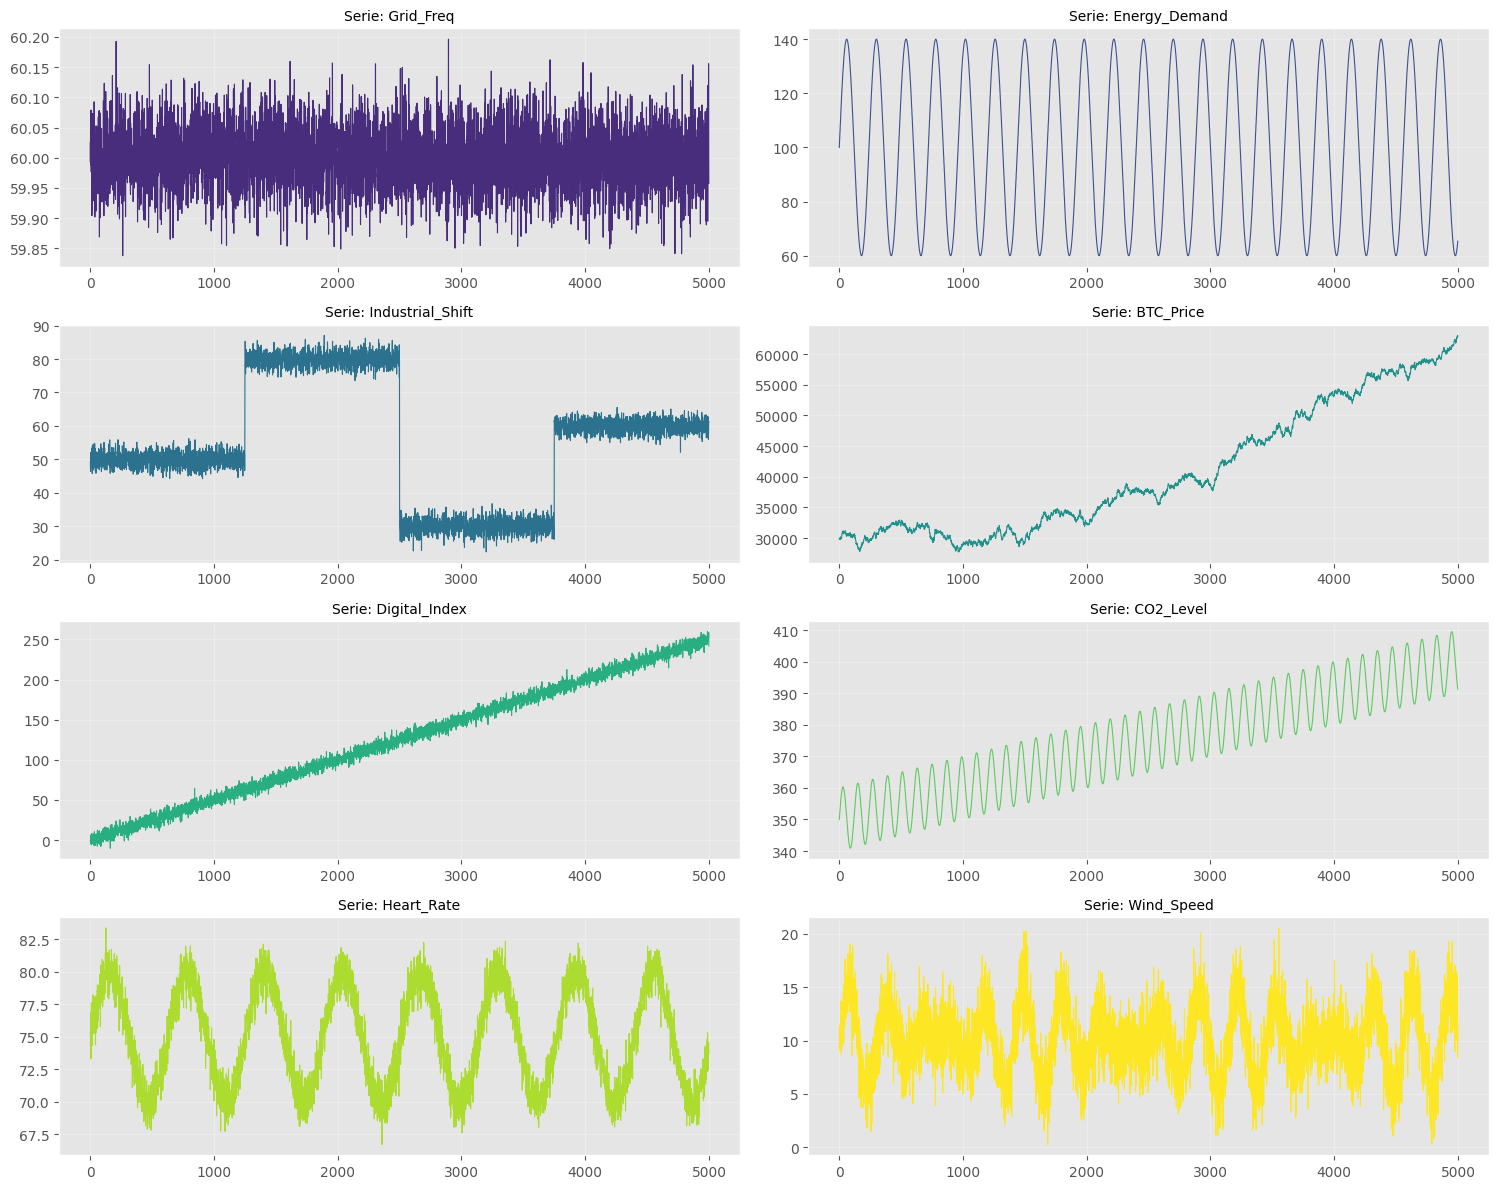

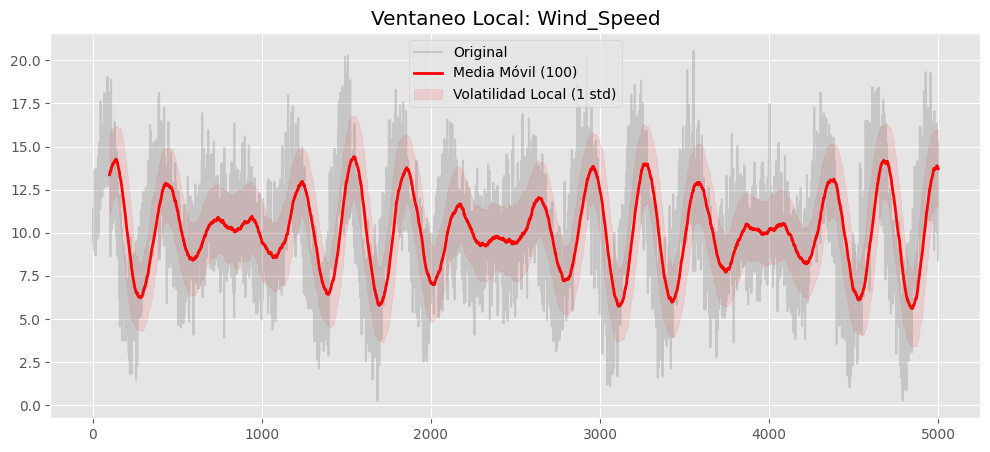

--- Dataset con Lags para Heart_Rate ---
    Heart_Rate      Lag_1      Lag_5     Lag_10
0    75.348286        NaN        NaN        NaN
1    75.333333  75.348286        NaN        NaN
2    74.163493  75.333333        NaN        NaN
3    75.729592  74.163493        NaN        NaN
4    73.709904  75.729592        NaN        NaN
5    74.595761  73.709904  75.348286        NaN
6    73.300792  74.595761  75.333333        NaN
7    76.908411  73.300792  74.163493        NaN
8    75.168104  76.908411  75.729592        NaN
9    77.616366  75.168104  73.709904        NaN
10   76.302217  77.616366  74.595761  75.348286
11   75.997099  76.302217  73.300792  75.333333
12   75.012453  75.997099  76.908411  74.163493
13   74.601950  75.012453  75.168104  75.729592
14   76.220826  74.601950  77.616366  73.709904
Serie dividida en 10 segmentos de tamaño 500


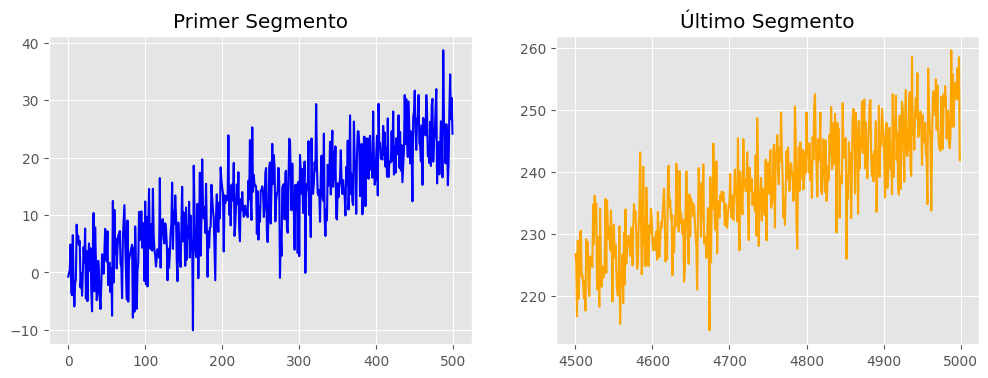

In [5]:
# =============================================================================
# BLOQUE INTERMEDIO: EXPLORACIÓN, VENTANEO Y MANIPULACIÓN (EDA TEMPORAL)
# =============================================================================

# 1. Visualización Estática Global
# Propósito: Observar escalas y tipos de señales en un solo vistazo.
def plot_all_static(df):
    plt.figure(figsize=(15, 12))
    for i, col in enumerate(df.columns, 1):
        plt.subplot(4, 2, i)
        plt.plot(df[col], color=plt.cm.viridis(i/8), linewidth=0.8)
        plt.title(f'Serie: {col}', fontsize=10)
        plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_all_static(df_clean)

# 2. Visualización Dinámica con Desplazamiento (Range Slider)
# Propósito: Permitir al investigador hacer zoom en eventos específicos.
def plot_interactive_exploration(df, cols=['BTC_Price', 'Energy_Demand']):
    fig = go.Figure()
    for col in cols:
        fig.add_trace(go.Scatter(x=df.index, y=df[col], name=col))

    fig.update_layout(
        title="Explorador de Series de Tiempo (Slicing & Zoom)",
        xaxis=dict(rangeslider=dict(visible=True), type="linear"),
        template="plotly_dark"
    )
    fig.show()

# Probemos con dos series de escalas diferentes
plot_interactive_exploration(df_clean)

# 3. Manipulación: Ventaneo (Windowing) y Estadísticos Móviles
# Propósito: Suavizado y detección de cambios en la varianza local.
def apply_windowing(df, column, window_size=100):
    # Ventana móvil para media y desviación estándar
    rolling_mean = df[column].rolling(window=window_size).mean()
    rolling_std = df[column].rolling(window=window_size).std()

    plt.figure(figsize=(12, 5))
    plt.plot(df[column], alpha=0.3, label='Original', color='gray')
    plt.plot(rolling_mean, label=f'Media Móvil ({window_size})', color='red', linewidth=2)
    plt.fill_between(df.index,
                     rolling_mean - rolling_std,
                     rolling_mean + rolling_std,
                     color='red', alpha=0.1, label='Volatilidad Local (1 std)')
    plt.title(f'Ventaneo Local: {column}')
    plt.legend()
    plt.show()

apply_windowing(df_clean, 'Wind_Speed')

# 4. Desplazamiento Temporal (Shifting / Lags)
# Propósito: Crear variables para modelos autoregresivos o medir desfases.
def create_lags(df, column, lags=[1, 5, 10]):
    temp_df = pd.DataFrame(df[column])
    for lag in lags:
        temp_df[f'Lag_{lag}'] = temp_df[column].shift(lag)

    print(f"--- Dataset con Lags para {column} ---")
    print(temp_df.head(15)) # Veremos los NaNs iniciales por el desplazamiento
    return temp_df

# Útil para análisis de correlación cruzada posterior
df_lags = create_lags(df_clean, 'Heart_Rate')

# 5. Segmentación por Bloques (Chunking)
# Propósito: Útil para análisis espectral segmentado o entrenamiento por batches.
def segment_data(series, segment_size=500):
    segments = [series[i:i + segment_size] for i in range(0, len(series), segment_size)]
    print(f"Serie dividida en {len(segments)} segmentos de tamaño {segment_size}")

    # Graficar el primer y último segmento para comparar evolución
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(segments[0], color='blue')
    ax[0].set_title("Primer Segmento")
    ax[1].plot(segments[-1], color='orange')
    ax[1].set_title("Último Segmento")
    plt.show()

segment_data(df_clean['Digital_Index'])

# =============================================================================
# COMENTARIOS DE BUENAS PRÁCTICAS PRE-PROCESO:
# 1. INSPECCIÓN DE NaNs: Al hacer 'shift' (desplazamiento) se generan valores nulos.
#    SIEMPRE decida si va a usar 'dropna()' o 'fillna()' antes del Bloque 2.
# 2. NORMALIZACIÓN: Si visualiza series juntas (BTC vs Frecuencia), las escalas
#    pueden ocultar patrones. Considere usar StandardScaler o MinMaxScaler.
# 3. OUTLIERS: Use el ventaneo de desviación estándar para detectar picos anómalos.
# =============================================================================

In [2]:
# =============================================================================
# BLOQUE 2: PROCESAMIENTO, SEGMENTACIÓN Y VISUALIZACIÓN VIVA
# =============================================================================

# --- Visualización Estática y Segmentación ---
def analyze_stationarity(series, name):
    result = adfuller(series)
    print(f'--- Test ADF para {name} ---')
    print(f'p-value: {result[1]:.4f}')
    return "Estacionaria" if result[1] < 0.05 else "No Estacionaria"

# Medir estacionariedad de una serie crítica
status = analyze_stationarity(df_clean['BTC_Price'], 'BTC_Price')

# --- Gráfica Viva (Animación de Ventana Móvil) ---
# Mostraremos los primeros 500 puntos moviéndose para eficiencia de renderizado
df_anim = df_clean.iloc[:500]

fig = go.Figure(
    data=[go.Scatter(x=[0], y=[df_anim['Energy_Demand'][0]], mode="lines", line=dict(color="orange", width=2))],
    layout=go.Layout(
        title="Gráfica Viva: Monitoreo de Demanda Energética",
        xaxis=dict(range=[0, 100], autorange=False),
        yaxis=dict(range=[50, 150], autorange=False),
        updatemenus=[dict(type="buttons", buttons=[dict(label="Play", method="animate", args=[None])])]
    ),
    frames=[go.Frame(data=[go.Scatter(x=list(range(i)), y=df_anim['Energy_Demand'][:i])]) for i in range(2, 200, 5)]
)
fig.show()



--- Test ADF para BTC_Price ---
p-value: 0.9960


**Proceso Intermedio**

In [6]:
# =============================================================================
# BLOQUE INTERMEDIO: LABORATORIO DE AJUSTE DE CURVAS (POLINOMIOS Y SPLINES)
# Propósito: Entender el trade-off entre sesgo y varianza (Overfitting vs Underfitting)
# =============================================================================

from scipy.interpolate import UnivariateSpline, CubicSpline

def lab_curvas_interactivo(series_name='CO2_Level'):
    """
    Laboratorio para jugar con la aproximación de funciones sobre series reales.
    Permite visualizar cómo diferentes grados de libertad capturan la tendencia.
    """
    # 1. Preparación de datos (usaremos un subconjunto para visualización clara)
    y = df_clean[series_name].values[:1000]
    x = np.arange(len(y))

    # ---------------------------------------------------------
    # PARTE A: AJUSTE POLINOMIAL (Regresión Global)
    # ---------------------------------------------------------
    # Ajustamos grados 2 (parábola) y grado 12 (complejo)
    p2_coefs = np.polyfit(x, y, 2)
    p12_coefs = np.polyfit(x, y, 12)

    p2 = np.polyval(p2_coefs, x)
    p12 = np.polyval(p12_coefs, x)

    # ---------------------------------------------------------
    # PARTE B: SPLINES (Aproximación por Tramos / Local)
    # ---------------------------------------------------------
    # UnivariateSpline: s es el factor de suavizado.
    # s=0 pasa por todos los puntos (interpola), s alto suaviza.
    spline_suave = UnivariateSpline(x, y, s=5000)
    spline_overfit = UnivariateSpline(x, y, s=0)

    # ---------------------------------------------------------
    # PARTE C: VISUALIZACIÓN COMPARATIVA
    # ---------------------------------------------------------
    fig = go.Figure()

    # Serie Original
    fig.add_trace(go.Scatter(x=x, y=y, mode='lines', name='Original',
                             line=dict(color='lightgray', width=1)))

    # Polinomios
    fig.add_trace(go.Scatter(x=x, y=p2, name='Poli Grado 2 (Tendencia Global)',
                             line=dict(color='blue', dash='dash')))
    fig.add_trace(go.Scatter(x=x, y=p12, name='Poli Grado 12 (Posible Overfit)',
                             line=dict(color='red', width=2)))

    # Splines
    fig.add_trace(go.Scatter(x=x, y=spline_suave(x), name='Spline Suave (B-Spline)',
                             line=dict(color='green', width=3)))

    fig.update_layout(
        title=f"Laboratorio de Suavizado: Análisis de la serie {series_name}",
        xaxis_title="Tiempo (Ticks)",
        yaxis_title="Valor",
        hovermode="x unified",
        template="plotly_white",
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
    )

    fig.show()

# Ejecutamos el laboratorio
lab_curvas_interactivo('CO2_Level')

# =============================================================================
# ACTIVIDAD PARA EL ESTUDIANTE (Análisis Crítico)
# =============================================================================
"""
OBSERVACIONES PARA EL ESTUDIANTE:
1. EFECTO RUNGE: Note cómo los polinomios de alto grado (Grado 12) tienden a oscilar
   violentamente en los bordes de la serie. Evite grados altos para extrapolación.

2. SPLINES VS POLINOMIOS: Los Splines son 'locales'. Si un tramo de la serie cambia
   bruscamente (como en 'Industrial_Shift'), el spline se adapta sin arruinar el
   ajuste en el resto de la serie. El polinomio, al ser global, se ve afectado en toda su curva.

3. USO EN PREPROCESAMIENTO: Estos métodos se usan para 'Detrending' (quitar la tendencia).
   Si usted resta el Spline Suave a la serie original, obtendrá los 'Residuos' o la
   componente estocástica para modelar con ARIMA.
"""

# Ejercicio: Pruebe con 'Industrial_Shift' para ver cómo los Splines manejan los saltos.
# lab_curvas_interactivo('Industrial_Shift')

"\nOBSERVACIONES PARA EL ESTUDIANTE:\n1. EFECTO RUNGE: Note cómo los polinomios de alto grado (Grado 12) tienden a oscilar \n   violentamente en los bordes de la serie. Evite grados altos para extrapolación.\n   \n2. SPLINES VS POLINOMIOS: Los Splines son 'locales'. Si un tramo de la serie cambia \n   bruscamente (como en 'Industrial_Shift'), el spline se adapta sin arruinar el \n   ajuste en el resto de la serie. El polinomio, al ser global, se ve afectado en toda su curva.\n\n3. USO EN PREPROCESAMIENTO: Estos métodos se usan para 'Detrending' (quitar la tendencia). \n   Si usted resta el Spline Suave a la serie original, obtendrá los 'Residuos' o la \n   componente estocástica para modelar con ARIMA.\n"

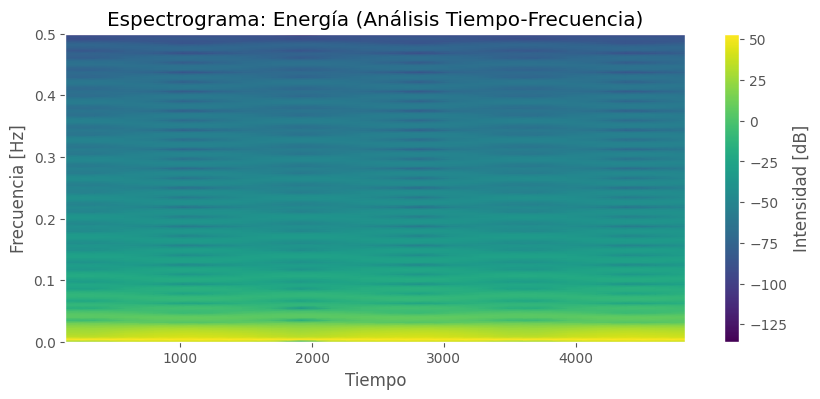

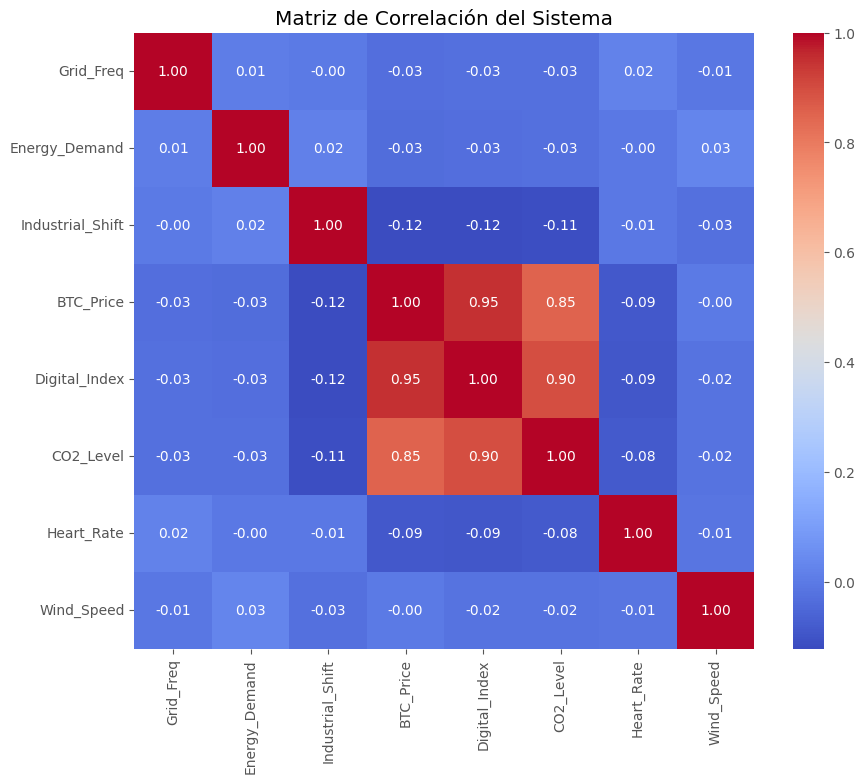

In [4]:
# =============================================================================
# BLOQUE 3: RUIDO (SNR), FILTRADO Y MODELADO
# =============================================================================

def add_noise(series, snr_db):
    """Agrega ruido blanco gaussiano basado en SNR."""
    sig_watts = np.var(series)
    sig_db = 10 * np.log10(sig_watts)
    noise_db = sig_db - snr_db
    noise_watts = 10 ** (noise_db / 10)
    return series + np.random.normal(0, np.sqrt(noise_watts), len(series))

# 1. Aplicar Ruido
df_noise = df_clean.copy()
df_noise['BTC_Price'] = add_noise(df_clean['BTC_Price'], snr_db=10)

# 2. Filtrado (Media Móvil para eliminar ruido de alta frecuencia)
# BUENA PRÁCTICA: No usar ventanas demasiado grandes que desplacen la fase de la señal.
df_noise['BTC_Filtered'] = df_noise['BTC_Price'].rolling(window=20).mean()

# 3. Análisis de Frecuencia (Espectrograma)
f, t_spec, Sxx = signal.spectrogram(df_clean['Energy_Demand'], fs=1.0)
plt.figure(figsize=(10, 4))
plt.pcolormesh(t_spec, f, 10 * np.log10(Sxx), shading='gouraud')
plt.title('Espectrograma: Energía (Análisis Tiempo-Frecuencia)')
plt.ylabel('Frecuencia [Hz]')
plt.xlabel('Tiempo')
plt.colorbar(label='Intensidad [dB]')
plt.show()

# 4. Modelado Temporal (ARIMA)
# Para BTC, que es I(1), aplicamos diferenciación d=1
model = ARIMA(df_clean['BTC_Price'], order=(1, 1, 0)) # AR(1)
results = model.fit()

# 5. Correlación
plt.figure(figsize=(10, 8))
sns.heatmap(df_clean.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación del Sistema')
plt.show()



**Bloque de Pensamiento Crítico:**

In [8]:
# =============================================================================
# BLOQUE 4: LABORATORIO DE ROBUSTEZ (CORREGIDO)
# =============================================================================

# ... (Las funciones butter_lowpass_filter y calcular_error_recuperacion se mantienen igual)

# --- 3. VISUALIZACIÓN COMPARATIVA DE "RESCATE DE SEÑAL" ---
fig = go.Figure()

# Serie Original (Clean)
fig.add_trace(go.Scatter(y=df_clean['BTC_Price'][:500],
                         name='Verdad (Clean)',
                         line=dict(color='green', width=2)))

# Serie Ruidosa (Corregido: usamos opacity en lugar de alpha)
fig.add_trace(go.Scatter(y=df_noise['BTC_Price'][:500],
                         name='Ruidosa (10dB)',
                         line=dict(color='red'),
                         opacity=0.3)) # <--- Aquí estaba el error

# Serie Recuperada
fig.add_trace(go.Scatter(y=df_noise['BTC_Butter'][:500],
                         name='Recuperada (Butterworth)',
                         line=dict(color='blue', width=2)))

fig.update_layout(
    title="Rescate de Señal: ¿Qué tanto ruido podemos eliminar?",
    xaxis_title="Tiempo (Ticks)",
    yaxis_title="Precio BTC",
    template="plotly_white"
)
fig.show()

In [10]:
# =============================================================================
# BLOQUE 5: PRONÓSTICO (FORECASTING) - VERSIÓN CORREGIDA
# Propósito: Proyectar la serie al futuro y visualizar bandas de confianza.
# =============================================================================

def proyectar_futuro(series, steps=100):
    # 1. Ajuste del modelo
    # 'enforce_invertibility=False' ayuda a evitar los warnings de parámetros iniciales
    # 'order=(1, 1, 1)' es un estándar para series con tendencia y estacionalidad simple
    try:
        model = ARIMA(series, order=(1, 1, 1), enforce_invertibility=False)
        model_fit = model.fit()
    except:
        # Fallback en caso de que el modelo no converja
        model = ARIMA(series, order=(1, 0, 0))
        model_fit = model.fit()

    # 2. Obtención del pronóstico
    forecast_obj = model_fit.get_forecast(steps=steps)
    yhat = forecast_obj.predicted_mean

    # conf_int puede venir como DataFrame o Numpy Array según la entrada
    conf_int = forecast_obj.conf_int()

    # 3. Manejo de tipos de datos (Fix para el error de .iloc)
    # Convertimos a Numpy si es un DataFrame para asegurar compatibilidad de indexación
    if isinstance(conf_int, pd.DataFrame):
        low_bound = conf_int.iloc[:, 0].values
        high_bound = conf_int.iloc[:, 1].values
    else:
        low_bound = conf_int[:, 0]
        high_bound = conf_int[:, 1]

    # 4. Construcción de ejes temporales
    last_idx = len(series)
    x_hist = np.arange(last_idx - 200, last_idx)
    x_futuro = np.arange(last_idx, last_idx + steps)

    # 5. Visualización con Plotly
    fig = go.Figure()

    # Histórico (Últimos 200 puntos)
    fig.add_trace(go.Scatter(x=x_hist, y=series[-200:],
                             name='Histórico (Actual)',
                             line=dict(color='black', width=1.5)))

    # Pronóstico (Media)
    fig.add_trace(go.Scatter(x=x_futuro, y=yhat,
                             name='Pronóstico (Mean)',
                             line=dict(color='red', dash='dash', width=2)))

    # Bandas de Confianza (Incertidumbre Aleatoria)
    # Usamos la técnica de "reversión" del eje X para cerrar el polígono del área
    fig.add_trace(go.Scatter(
        x=np.concatenate([x_futuro, x_futuro[::-1]]),
        y=np.concatenate([high_bound, low_bound[::-1]]),
        fill='toself',
        fillcolor='rgba(255, 0, 0, 0.15)',
        line=dict(color='rgba(255, 255, 255, 0)'),
        hoverinfo="skip",
        showlegend=True,
        name='Intervalo de Confianza (95%)'
    ))

    fig.update_layout(
        title="Proyección de Serie Temporal: Análisis de Incertidumbre",
        xaxis_title="Tiempo (Ticks)",
        yaxis_title="Valor de la Variable",
        template="plotly_white",
        hovermode="x unified"
    )
    fig.show()

# Probamos la proyección (Se puede pasar con o sin .values)
proyectar_futuro(df_clean['Energy_Demand'])

# =============================================================================
# COMENTARIOS TÉCNICOS PARA EL ESTUDIANTE
# =============================================================================
"""
1. TRATAMIENTO DE DATOS: Observe cómo el código ahora detecta si la entrada es
   un array de Numpy o un objeto de Pandas para evitar errores de atributo.

2. ENFORCE_INVERTIBILITY: Al ponerlo en False, permitimos que el optimizador
   de Statsmodels encuentre una solución aunque los parámetros iniciales no sean ideales.

3. INCERTIDUMBRE: Note que el área sombreada se ensancha conforme nos alejamos
   del presente. Esto cuantifica el riesgo en la toma de decisiones.
"""

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



'\n1. TRATAMIENTO DE DATOS: Observe cómo el código ahora detecta si la entrada es \n   un array de Numpy o un objeto de Pandas para evitar errores de atributo.\n   \n2. ENFORCE_INVERTIBILITY: Al ponerlo en False, permitimos que el optimizador \n   de Statsmodels encuentre una solución aunque los parámetros iniciales no sean ideales.\n\n3. INCERTIDUMBRE: Note que el área sombreada se ensancha conforme nos alejamos \n   del presente. Esto cuantifica el riesgo en la toma de decisiones.\n'